# XBD Dataset Analysis

## Folder structure

In [202]:
import sys
sys.path.append("../src")
from utils.common.pathManager import FilePath
from collections import defaultdict
from shapely import wkt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cv2 import imread
import pandas as pd
path = FilePath("/media/mrtc101/Martín SSD/tesis/datasets/xBD")
print(path.get_folder_names())

['hold', 'test', 'tier3', 'train']


In [141]:
count_types = defaultdict(lambda : 0)
for split_folder in path.get_folder_paths():
    for folder in split_folder.get_folder_names():
        if(folder == "images"):
            split_path = split_folder.join(folder)
            for file in split_path.get_files_names():
                if file.find("pre") > -1:
                    prefix = file.split("_")[0]
                    count_types[prefix] += 1
[(t,n) for t,n in count_types.items()]

[('guatemala-volcano', 28),
 ('hurricane-florence', 546),
 ('midwest-flooding', 445),
 ('socal-fire', 1403),
 ('hurricane-matthew', 405),
 ('hurricane-harvey', 522),
 ('hurricane-michael', 550),
 ('santa-rosa-wildfire', 377),
 ('palu-tsunami', 196),
 ('mexico-earthquake', 193),
 ('joplin-tornado', 149),
 ('lower-puna-volcano', 291),
 ('moore-tornado', 227),
 ('nepal-flooding', 619),
 ('pinery-bushfire', 1845),
 ('portugal-wildfire', 1869),
 ('sunda-tsunami', 148),
 ('tuscaloosa-tornado', 343),
 ('woolsey-fire', 878)]

## Load label Files

In [142]:
json_files = defaultdict(lambda : [])
for split_name in path.get_folder_names():
    split_folder = path.join(split_name)
    for file_folder in split_folder.get_folder_names():
        if(file_folder == "labels"):
            folder_path = split_folder.join(file_folder)
            for json_name in folder_path.get_files_names():
                prefix = img_name.split("_")[0]
                img_path = folder_path.join(img_name)
                json_files[prefix].append(img_path)
disasters = [k for k in json_files.keys()]
disasters

['guatemala-volcano',
 'hurricane-florence',
 'midwest-flooding',
 'hurricane-matthew',
 'socal-fire',
 'santa-rosa-wildfire',
 'hurricane-harvey',
 'hurricane-michael',
 'palu-tsunami',
 'mexico-earthquake',
 'joplin-tornado',
 'lower-puna-volcano',
 'moore-tornado',
 'nepal-flooding',
 'pinery-bushfire',
 'portugal-wildfire',
 'sunda-tsunami',
 'tuscaloosa-tornado',
 'woolsey-fire']

## Look at a label JSON

Examine one JSON file in the `labels` folder...

In [143]:
example_path_post = json_files['joplin-tornado'][0]
example_path_pre = json_files['joplin-tornado'][1]
print(example_path_post)
print(example_path_pre)

/media/mrtc101/Martín SSD/tesis/datasets/xBD/tier3/labels/joplin-tornado_00000000_post_disaster.json
/media/mrtc101/Martín SSD/tesis/datasets/xBD/tier3/labels/joplin-tornado_00000000_pre_disaster.json


In [144]:
example_post = example_path_post.read_json()

def recurrent(k,element):
    if isinstance(element, dict):
        print(f"{k} dict: ", list(element.keys()))
        for k in element.keys():
            recurrent(k,element[k])
    if isinstance(element, list):
        print(f"{k} list length: {len(element)}")
recurrent("example", example_post)

example dict:  ['features', 'metadata']
features dict:  ['lng_lat', 'xy']
lng_lat list length: 185
xy list length: 185
metadata dict:  ['sensor', 'provider_asset_type', 'gsd', 'capture_date', 'off_nadir_angle', 'pan_resolution', 'sun_azimuth', 'sun_elevation', 'target_azimuth', 'disaster', 'disaster_type', 'catalog_id', 'original_width', 'original_height', 'width', 'height', 'id', 'img_name']


Pre-disaster labels have no `subtype` filed or label assigned. We assume all labels are `1 - 'no damage'`

In [145]:
building = example_post['features']['xy'][0]
recurrent("building", building)
print(building['properties'])

building dict:  ['properties', 'wkt']
properties dict:  ['feature_type', 'subtype', 'uid']
{'feature_type': 'building', 'subtype': 'destroyed', 'uid': 'b6aa615e-56b2-458a-b404-d094b64dcad3'}


In [146]:
example_pre = example_path_pre.read_json()
recurrent("building", example_pre['features']['xy'][0])
example_pre['features']['xy'][0]['properties']
#NO SUBTYPE KEY

building dict:  ['properties', 'wkt']
properties dict:  ['feature_type', 'uid']


{'feature_type': 'building', 'uid': 'b6aa615e-56b2-458a-b404-d094b64dcad3'}

In [147]:
example_post['metadata']

{'sensor': 'WORLDVIEW02',
 'provider_asset_type': 'WORLDVIEW02',
 'gsd': 2.35255861282349,
 'capture_date': '2011-05-29T17:29:25.433Z',
 'off_nadir_angle': 28.4302768707275,
 'pan_resolution': 0.585882604122162,
 'sun_azimuth': 143.603851318359,
 'sun_elevation': 71.8531799316406,
 'target_azimuth': 193.251083374023,
 'disaster': 'joplin-tornado',
 'disaster_type': 'wind',
 'catalog_id': '103001000A285500',
 'original_width': 1024,
 'original_height': 1024,
 'width': 1024,
 'height': 1024,
 'id': 'MjY0Mzk4Mg.vo5dFUhTfoVWnKNLRID8rEkx0A0',
 'img_name': 'joplin-tornado_00000000_post_disaster.png'}

### Reading a Polygon with shapely

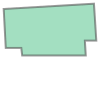

In [148]:
bld = wkt.loads(building['wkt'])
bld

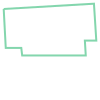

In [149]:
bld.boundary

In [150]:
bld.area

942.9761590092912

## Class distribution analysis

In [151]:
not_building = []
labels = set()
buildings = []
for disaster_name, files_list in tqdm(json_files.items()):
    for file_path in tqdm(files_list):
        label_json = file_path.read_json()
        for building in label_json['features']['xy']:
            
            if building['properties']['feature_type'] != 'building':
                not_building.append(building)
            time_prefix = "pre" if file_path.find("pre") >= 0 else "post"
            dmg_label = building['properties'].get('subtype','no-damage')
            labels.add(dmg_label)
            tile_id = FilePath(file_path).basename().split("_")[1]
            buildings.append([disaster_name, tile_id, time_prefix, dmg_label, building['wkt']])
building_df = pd.DataFrame(buildings, columns=["dis_id", "tile_id", "time_prefix", "labels", "wkt"])

100%|██████████| 19/19 [00:38<00:00,  2.02s/it]


In [152]:
print(f"Not buildings {len(not_building)}")
labels

Not buildings 0


{'destroyed', 'major-damage', 'minor-damage', 'no-damage', 'un-classified'}

In [153]:
building_df

,dis_id,tile_id,time_prefix,labels,wkt
0,guatemala-volcano,00000004,post,major-damage,"POLYGON ((212.2425241572 0.005244624768526229,..."
1,guatemala-volcano,00000004,post,major-damage,"POLYGON ((111.0102139006811 45.00256966117878,..."
2,guatemala-volcano,00000004,post,major-damage,"POLYGON ((70.80872744088899 136.8631511105073,..."
3,guatemala-volcano,00000004,post,major-damage,"POLYGON ((101.7572618843397 143.6071892445766,..."
4,guatemala-volcano,00000004,post,major-damage,"POLYGON ((151.2496055086376 218.2691614266855,..."
...,...,...,...,...,...
850731,woolsey-fire,00000871,pre,no-damage,"POLYGON ((456.3517456901946 602.4305091848393,..."
850732,woolsey-fire,00000871,pre,no-damage,"POLYGON ((541.5926455670866 583.4702351452573,..."
850733,woolsey-fire,00000871,pre,no-damage,"POLYGON ((524.8688907831191 643.1025081251053,..."
850734,woolsey-fire,00000871,pre,no-damage,"POLYGON ((541.9189263733463 650.3631925910292,..."


Here we can see the number of disasters, number of tiles, and number of buildings polygons from xBD dataset.

In [154]:
building_df.describe()

,dis_id,tile_id,time_prefix,labels,wkt
count,850736,850736,850736,850736,850736
unique,19,1592,2,5,850736
top,palu-tsunami,00000118,post,no-damage,"POLYGON ((212.2425241572 0.005244624768526229,..."
freq,111578,5716,425368,738401,1


In [155]:
total_buildings = len(building_df)
total_buildings

850736

## Building count

### Number of tiles per disaster

In [156]:
tile_by_disaster =building_df.value_counts(["dis_id","tile_id"]).unstack()
(tile_by_disaster > 0 & ~tile_by_disaster.isna()).sum(axis=1)

dis_id
guatemala-volcano       27
hurricane-florence     520
hurricane-harvey       492
hurricane-matthew      379
hurricane-michael      534
joplin-tornado         148
lower-puna-volcano     183
mexico-earthquake      193
midwest-flooding       392
moore-tornado          222
nepal-flooding         576
palu-tsunami           193
pinery-bushfire        479
portugal-wildfire      975
santa-rosa-wildfire    368
socal-fire             700
sunda-tsunami          105
tuscaloosa-tornado     288
woolsey-fire           402
dtype: int64

### Number of buildings per tile

In [157]:
tile_by_disaster

tile_id,00000000,00000001,00000002,00000003,00000004,00000005,00000006,00000007,00000008,00000009,...,00001854,00001855,00001856,00001858,00001859,00001860,00001861,00001863,00001864,00001866
dis_id,,,,,,,,,,,,,,,,,,,,,
guatemala-volcano,20.0,8.0,2.0,6.0,40.0,2.0,194.0,18.0,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hurricane-florence,220.0,182.0,12.0,132.0,168.0,154.0,228.0,32.0,46.0,574.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hurricane-harvey,60.0,270.0,362.0,74.0,310.0,220.0,96.0,74.0,80.0,376.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hurricane-matthew,210.0,4.0,76.0,236.0,NaN,142.0,NaN,66.0,4.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hurricane-michael,108.0,186.0,10.0,70.0,6.0,4.0,12.0,4.0,56.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
joplin-tornado,370.0,396.0,206.0,326.0,512.0,80.0,72.0,670.0,86.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lower-puna-volcano,2.0,12.0,4.0,4.0,44.0,12.0,NaN,56.0,22.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mexico-earthquake,898.0,344.0,572.0,1864.0,340.0,568.0,1206.0,870.0,572.0,488.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
midwest-flooding,10.0,286.0,22.0,382.0,178.0,6.0,10.0,108.0,24.0,172.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Number of buildings per disaster

In [158]:
bld_num_by_disaster = building_df.value_counts(["dis_id"])
bld_num_by_disaster

dis_id             
palu-tsunami           111578
mexico-earthquake      102946
nepal-flooding          86530
hurricane-harvey        75910
hurricane-michael       71002
hurricane-matthew       47928
portugal-wildfire       46826
moore-tornado           45916
santa-rosa-wildfire     43910
socal-fire              37938
sunda-tsunami           33894
joplin-tornado          30704
tuscaloosa-tornado      30012
midwest-flooding        27792
hurricane-florence      23096
woolsey-fire            14030
pinery-bushfire         11922
lower-puna-volcano       6820
guatemala-volcano        1982
Name: count, dtype: int64

## Label count

In [159]:
building_df.value_counts(["time_prefix"])

time_prefix
post           425368
pre            425368
Name: count, dtype: int64

In [160]:
dmg_df = building_df[building_df["time_prefix"]=="post"]

### Number of labels

In [161]:
total_labels = dmg_df.value_counts(["labels"])
total_labels

labels       
no-damage        313033
minor-damage      36860
destroyed         31560
major-damage      29904
un-classified     14011
Name: count, dtype: int64

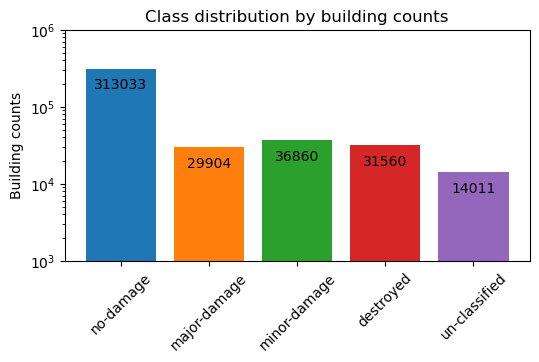

In [164]:
from matplotlib import axes
width = 0.8  # the width of the bars
ax : axes.Axes
fig, ax  = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
for i, label in enumerate(labels):
    y = total_labels[label]
    bar = ax.bar(label, y, width,)
    ax.text( label, round(y-(y/2)),
            f'{y:.0f}', ha='center', va='bottom')
ax.set_yscale('log')
ax.set_ylim(10**3, 10**6)
ax.set_ylabel('Building counts')
ax.set_title('Class distribution by building counts')
ax.set_xticks(list(range(len(labels))), labels)
_ = ax.set_xticklabels(labels, rotation=45)

### Number of labels per disaster

In [165]:
labels_per_disaster = dmg_df.value_counts(["labels","dis_id"])
print("no-damage\n".upper(),labels_per_disaster['no-damage'])

NO-DAMAGE
 dis_id
mexico-earthquake      51084
palu-tsunami           46796
nepal-flooding         31225
hurricane-michael      22692
portugal-wildfire      20787
moore-tornado          19453
hurricane-harvey       18638
santa-rosa-wildfire    15843
socal-fire             15697
sunda-tsunami          14078
midwest-flooding       12819
tuscaloosa-tornado     10499
hurricane-florence      8466
joplin-tornado          8225
pinery-bushfire         5027
woolsey-fire            4638
hurricane-matthew       4058
lower-puna-volcano      2277
guatemala-volcano        731
Name: count, dtype: int64


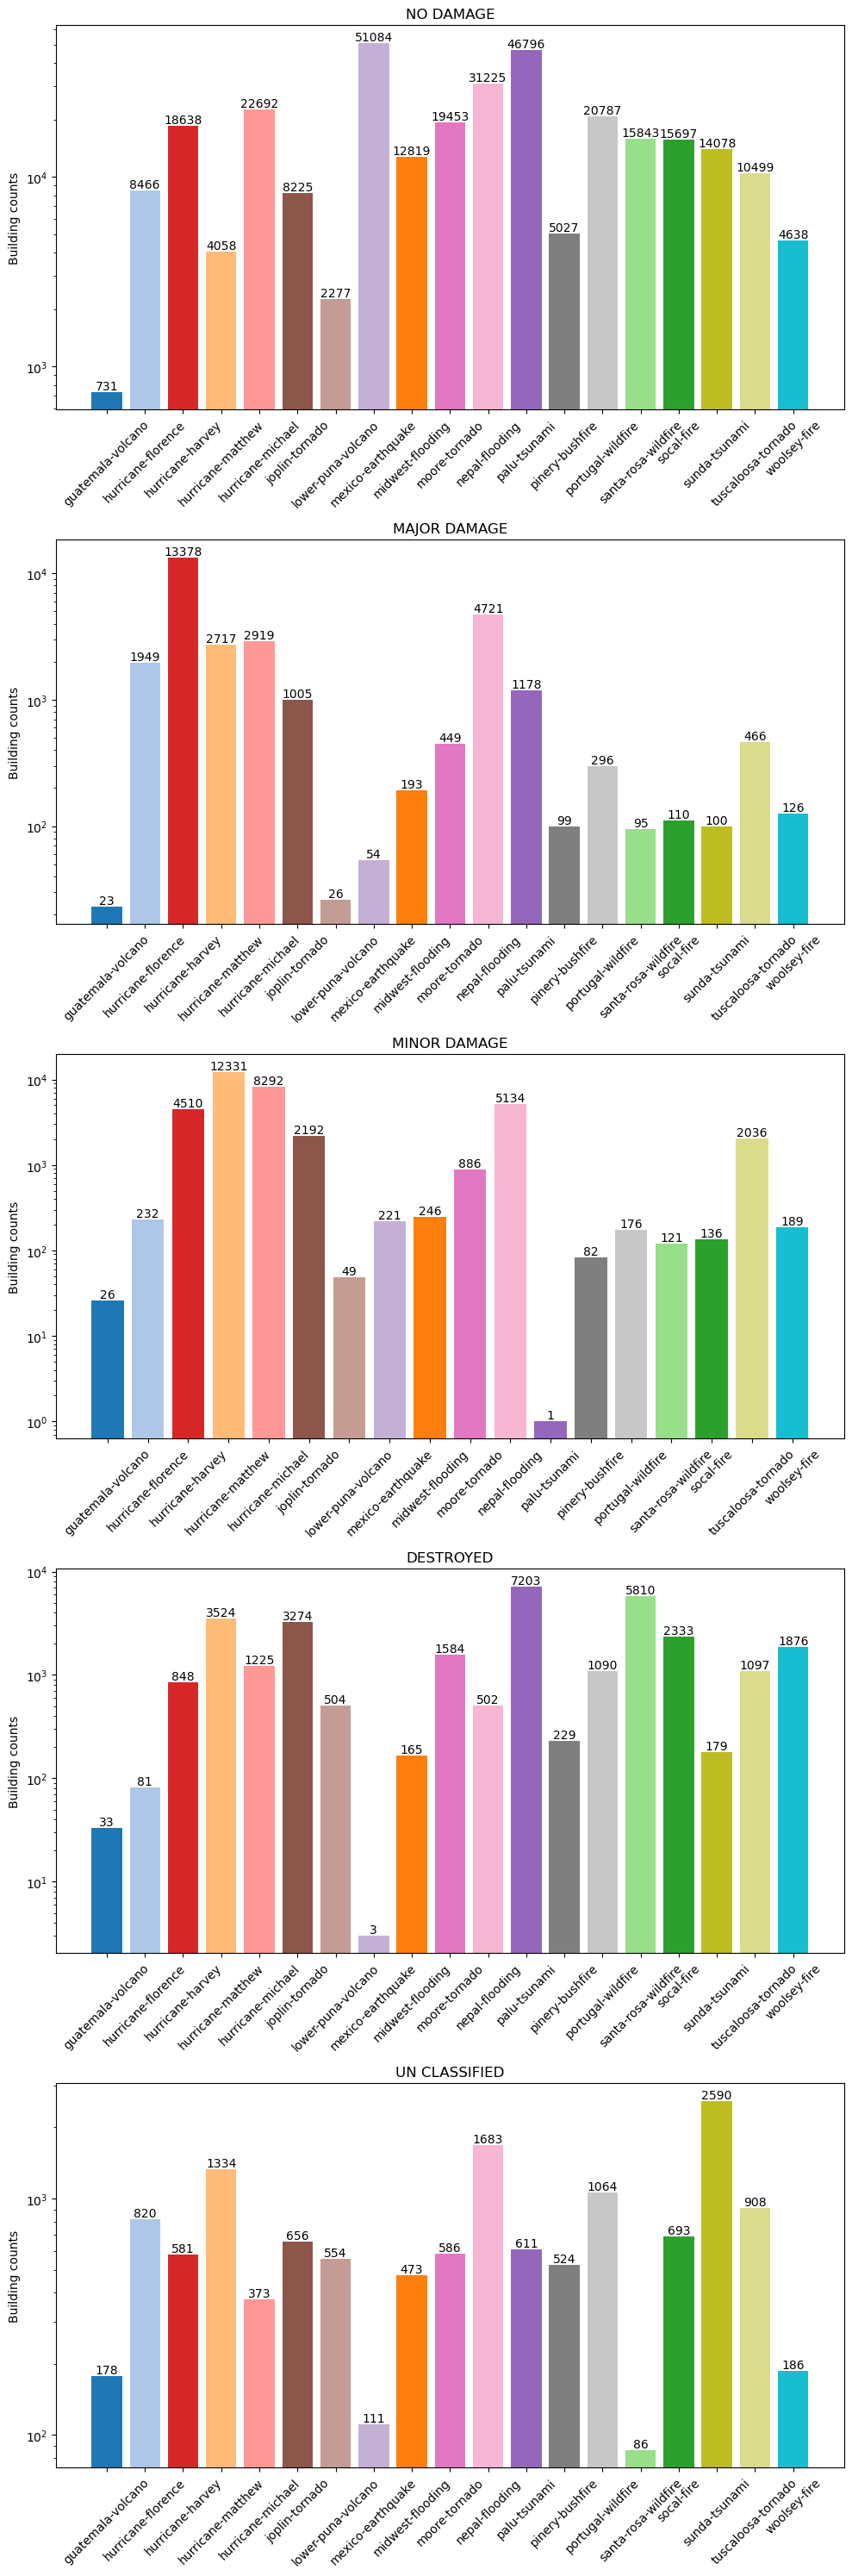

In [166]:
fig, axs = plt.subplots(len(labels), 1, figsize=(10, 6 * len(labels)), dpi=100)
ax : axes.Axes
colors = plt.colormaps['tab20']
color_map = {label: colors(i) for i, label in enumerate(disasters)}

for i, (ax, label) in enumerate(zip(axs, labels)):
    curr_series : pd.Series = labels_per_disaster[label]
    curr_series = curr_series.sort_index()    
    x = list(curr_series.index)
    y = list(curr_series.values)
    width = 0.8  # the width of the bars
    for j, (lab, height) in enumerate(zip(x,y)):
        ax.bar(j, height, width, color=color_map[lab], label=lab)
        ax.text(j, height, f'{height:.0f}',
                 ha='center', va='bottom')
    ax.set_ylabel(f'Building counts')
    ax.set_title(str(label).upper().replace("-"," "))
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x, rotation=45)
    ax.set_yscale('log')
    #ax.legend(fontsize='small')

fig.tight_layout()
plt.show()

## building area by label per disaster

In [167]:
areas = dmg_df['wkt'].apply(lambda x: wkt.loads(x).area)
areas

0          1242.745147
1          1235.182209
2         13072.973942
3           864.434750
4           274.401850
              ...     
850726      139.424338
850727      230.154380
850728       40.912904
850729      154.035881
850730       81.089937
Name: wkt, Length: 425368, dtype: float64

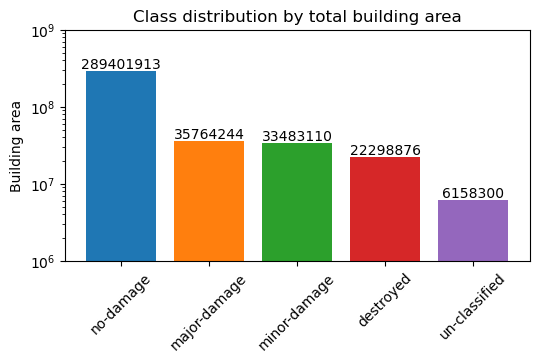

In [168]:
from matplotlib import axes
width = 0.8  # the width of the bars
ax : axes.Axes
fig, ax  = plt.subplots(1, 1, figsize=(6, 3), dpi=100)
for i, label in enumerate(labels):    
    y = areas[(dmg_df['labels'] == label)].sum()
    bar = ax.bar(label, y, width,)
    ax.text( label, y,
            f'{y:.0f}', ha='center', va='bottom')
ax.set_yscale('log')
ax.set_ylim(10**6,10**9)
ax.set_ylabel('Building area')
ax.set_title('Class distribution by total building area')
ax.set_xticks(list(range(len(labels))), labels)
_ = ax.set_xticklabels(labels, rotation=45)

## Correlation analysis of labels per disaster

In [174]:
labels_by_disaster_df = labels_per_disaster.unstack().transpose()
labels_by_disaster_df

labels,destroyed,major-damage,minor-damage,no-damage,un-classified
dis_id,,,,,
guatemala-volcano,33.0,23.0,26.0,731.0,178.0
hurricane-florence,81.0,1949.0,232.0,8466.0,820.0
hurricane-harvey,848.0,13378.0,4510.0,18638.0,581.0
hurricane-matthew,3524.0,2717.0,12331.0,4058.0,1334.0
hurricane-michael,1225.0,2919.0,8292.0,22692.0,373.0
joplin-tornado,3274.0,1005.0,2192.0,8225.0,656.0
lower-puna-volcano,504.0,26.0,49.0,2277.0,554.0
mexico-earthquake,3.0,54.0,221.0,51084.0,111.0
midwest-flooding,165.0,193.0,246.0,12819.0,473.0


In [175]:
correlation_matrix = labels_by_disaster_df.corr()
correlation_matrix

labels,destroyed,major-damage,minor-damage,no-damage,un-classified
labels,,,,,
destroyed,1.000000,-0.072105,0.068961,0.253817,-0.166782
major-damage,-0.072105,1.000000,0.454813,0.117501,0.084571
minor-damage,0.068961,0.454813,1.000000,-0.056676,0.486441
no-damage,0.253817,0.117501,-0.056676,1.000000,-0.028227
un-classified,-0.166782,0.084571,0.486441,-0.028227,1.000000


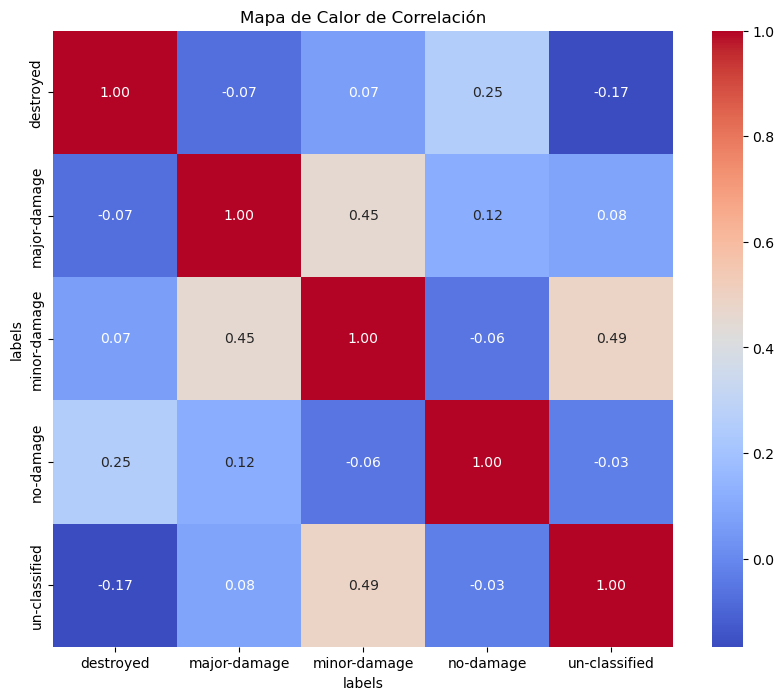

In [176]:
# Crea el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlación')
plt.show()

In [196]:
labels_by_disaster_df.describe()

labels,destroyed,major-damage,minor-damage,no-damage,un-classified
count,19.000000,19.000000,18.000000,19.000000,19.000000
mean,1661.052632,1573.894737,2047.777778,16475.421053,737.421053
std,2014.697178,3134.897498,3447.384048,13881.133512,606.094448
min,3.000000,23.000000,1.000000,731.000000,86.000000
25%,204.000000,99.500000,124.750000,6626.000000,423.000000
50%,1090.000000,296.000000,226.500000,14078.000000,586.000000
75%,2104.500000,1563.500000,2153.000000,20120.000000,864.000000
max,7203.000000,13378.000000,12331.000000,51084.000000,2590.000000


## Correlation analysis of labels per tile

In [178]:
labels_by_tile_df = dmg_df.value_counts(['dis_id','tile_id','labels']).unstack()
labels_by_tile_df[labels_by_tile_df.isna()] = 0.0
labels_by_tile_df

labels                      destroyed  major-damage  minor-damage  no-damage  \
dis_id            tile_id                                                      
guatemala-volcano 00000000        0.0           0.0           0.0       10.0   
                  00000001        0.0           0.0           4.0        0.0   
                  00000002        1.0           0.0           0.0        0.0   
                  00000003        1.0           0.0           2.0        0.0   
                  00000004        4.0           8.0           6.0        2.0   
...                               ...           ...           ...        ...   
woolsey-fire      00000865        1.0           0.0           1.0        9.0   
                  00000866        0.0           0.0           0.0        6.0   
                  00000867        3.0           0.0           3.0        8.0   
                  00000869        5.0           0.0           0.0        0.0   
                  00000871        0.0           0.0           1.0        4.0   

labels                      un-classified  
dis_id            tile_id                  
guatemala-volcano 00000000            0.0  
                  00000001            0.0  
                  00000002            0.0  
                  00000003            0.0  
                  00000004            0.0  
...                                   ...  
woolsey-fire      00000865            0.0  
                  00000866            0.0  
                  00000867            0.0  
                  00000869            0.0  
                  00000871            0.0  

[7176 rows x 5 columns]

In [179]:
labels_by_tile_df.corr()

labels,destroyed,major-damage,minor-damage,no-damage,un-classified
labels,,,,,
destroyed,1.000000,0.083031,0.027278,0.033393,0.009020
major-damage,0.083031,1.000000,0.197888,-0.036075,0.007446
minor-damage,0.027278,0.197888,1.000000,0.003632,0.062345
no-damage,0.033393,-0.036075,0.003632,1.000000,0.087057
un-classified,0.009020,0.007446,0.062345,0.087057,1.000000


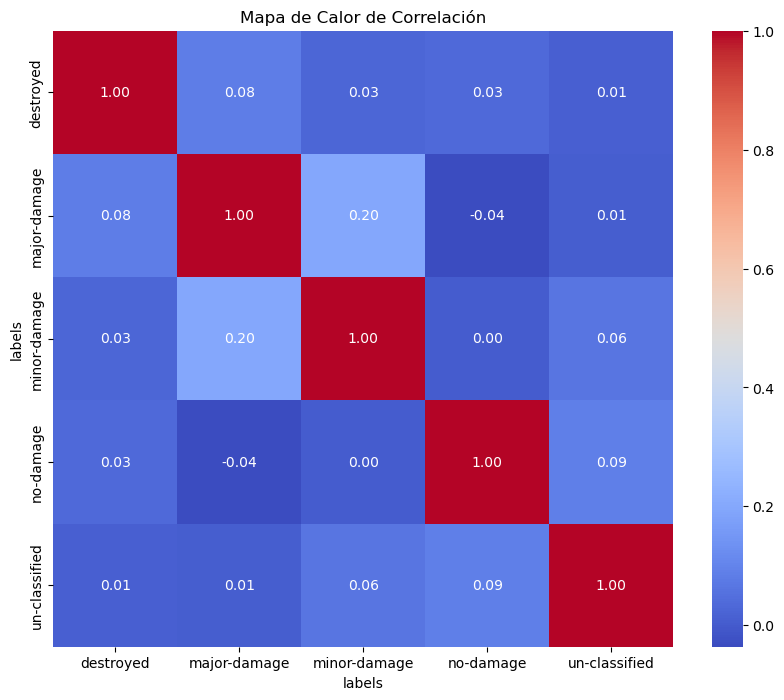

In [180]:
plt.figure(figsize=(10, 8))
sns.heatmap(labels_by_tile_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlación')
plt.show()

## pixel color distribution

In [197]:
image_files = defaultdict(lambda : [])
for split_name in path.get_folder_names():
    split_folder = path.join(split_name)
    for file_folder in split_folder.get_folder_names():
        if(file_folder == "images"):
            folder_path = split_folder.join(file_folder)
            for img_name in folder_path.get_files_names():
                prefix = img_name.split("_")[0]
                img_path = folder_path.join(img_name)
                image_files[prefix].append(img_path)

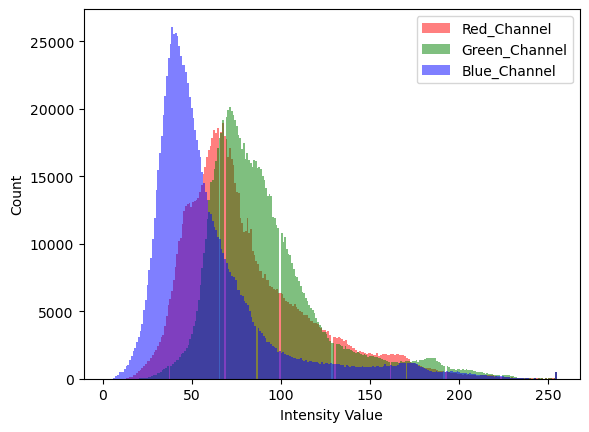

In [212]:
# plot histogram of the channels for entire dataset
import matplotlib.pyplot as plt
img = imread(image_files['guatemala-volcano'][0])
_ = plt.hist(img[:, :, 2].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(img[:, :, 0].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

# Imbalance class Analysis

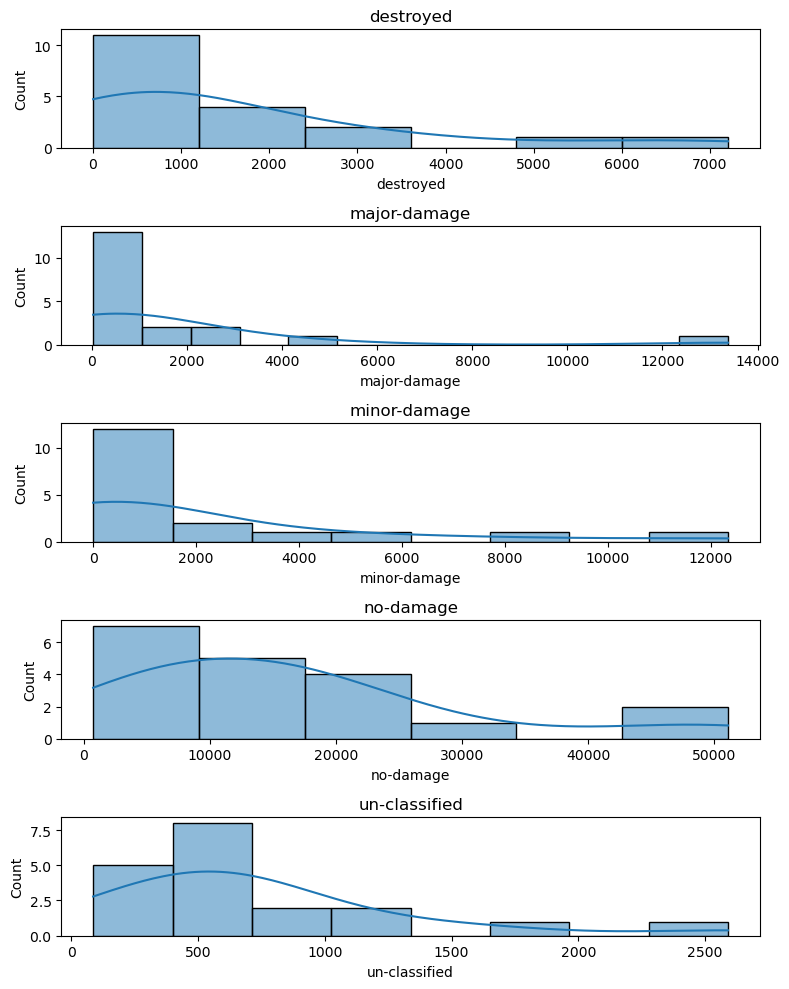

In [232]:
df = labels_by_disaster_df
num_columns = len(df.columns)
fig, axes = plt.subplots(num_columns, 1, figsize=(8, 2 * num_columns), dpi=100)

for i, column in enumerate(df.columns):
    sns.histplot(df[column], ax=axes[i], kde=True)
    axes[i].set_title(f'{column}')

plt.tight_layout()
plt.show()

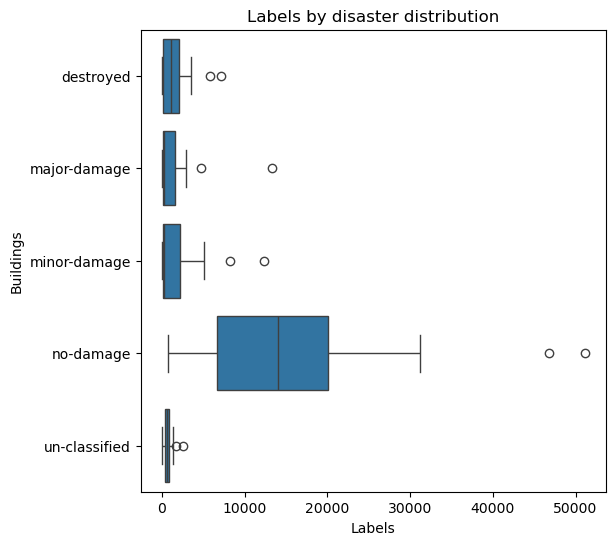

In [229]:
df_long = labels_by_disaster_df.melt(var_name='Buildings', value_name='Labels')

# Crear el boxplot con seaborn
plt.figure(figsize=(6, 6))
sns.boxplot(x='Labels', y='Buildings', data=df_long, orient='h')
plt.title('Labels by disaster distribution')
plt.show()

## weights for training

$ \text{Peso de la clase} = \frac{N_{total}}{N_{clase}​C}$​​

Where:
- $N_{total}$ is the total number of samples from dataset.
- $N_{clase}$ is the total number of samples from class.
- $​C$ is the total number of classes.

In [237]:
for lab in labels:
    den = len(labels) * (dmg_df["labels"]== lab).sum()
    print(f"{lab}_w = {len(dmg_df) / den}")

no-damage_w = 0.27177198570118805
major-damage_w = 2.8448903156768326
minor-damage_w = 2.308019533369506
destroyed_w = 2.695614702154626
un-classified_w = 6.071914923988295


Not using these because we need those from the training split only.

# Image analysis

## mask from json file with matplotlib

In [185]:
one_disaster_df = dmg_df[(dmg_df['dis_id'] == 'guatemala-volcano') & (dmg_df['tile_id'] == '00000004')]
one_disaster_df

,dis_id,tile_id,time_prefix,labels,wkt
0,guatemala-volcano,00000004,post,major-damage,"POLYGON ((212.2425241572 0.005244624768526229,..."
1,guatemala-volcano,00000004,post,major-damage,"POLYGON ((111.0102139006811 45.00256966117878,..."
2,guatemala-volcano,00000004,post,major-damage,"POLYGON ((70.80872744088899 136.8631511105073,..."
3,guatemala-volcano,00000004,post,major-damage,"POLYGON ((101.7572618843397 143.6071892445766,..."
4,guatemala-volcano,00000004,post,major-damage,"POLYGON ((151.2496055086376 218.2691614266855,..."
5,guatemala-volcano,00000004,post,destroyed,"POLYGON ((212.8923518446862 216.7481324907521,..."
6,guatemala-volcano,00000004,post,major-damage,"POLYGON ((298.4694509179649 184.6854995545669,..."
7,guatemala-volcano,00000004,post,minor-damage,"POLYGON ((347.2500761227303 171.0624496623539,..."
8,guatemala-volcano,00000004,post,minor-damage,"POLYGON ((229.3383858866266 135.9775609201506,..."
9,guatemala-volcano,00000004,post,minor-damage,"POLYGON ((285.1482771107765 64.10219417566604,..."


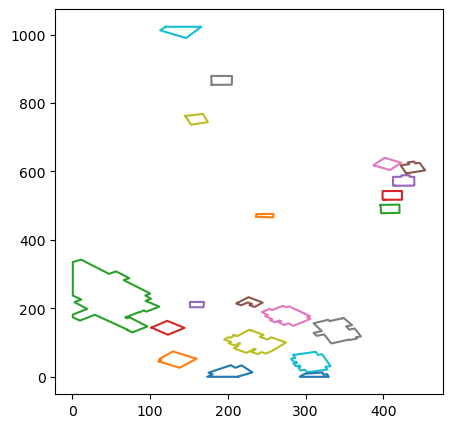

In [195]:
plt.figure(figsize=(5, 5))
for i, building in one_disaster_df.iterrows():
    poly = wkt.loads(building['wkt'])
    x, y = poly.exterior.xy
    plt.plot(x, y)

plt.show()

# Inspect target masks

This notebook demonstrates how to use the `RasterLabelVisualizer` class in `ai4eutils` to visualize the masks with our colormap. 

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # default is ‘last_expr’

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('./lib/ai4eutils')
import json
import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from geospatial.visualization.raster_label_visualizer import RasterLabelVisualizer
# label_map can also take path to a json that contains the colormap, 
# which is at constants/class_lists/label_map.json

viz = RasterLabelVisualizer(label_map='../constants/class_lists/label_map.json')
l = viz.plot_color_legend()

target_dir = './nlrc-damage-assessment/public_datasets/xBD/raw/train/targets_border2'
target_paths = sorted([os.path.join(target_dir, i) for i in os.listdir(target_dir) if i.startswith('palu-tsunami')])
len(target_paths)

p = target_paths[8]
p
p_np = np.array(Image.open(p))
p_np.shape
np.unique(p_np)

im, buf = viz.show_label_raster(p_np, size=(15, 15))
im

p = target_paths[9]
p
p_np = np.array(Image.open(p))
p_np.shape
np.unique(p_np)

im, buf = viz.show_label_raster(p_np, size=(15, 15))
im

# Images and mask visualization

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def supp(img, target):
    img_disaster = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    target[target[:, :, 0] == 1] = [70, 70, 70]
    target[target[:, :, 0] == 2] = [178, 255, 102]
    target[target[:, :, 0] == 3] = [194, 255, 94]
    target[target[:, :, 0] == 4] = [255, 139, 51]
    target[target[:, :, 0] == 5] = [255, 19, 19]

    alpha = 0.7  # Ajustar la transparencia de la segunda imagen
    superposed_image = cv2.addWeighted(img_disaster, 0.8, target, alpha, 0)
    return superposed_image


def visualize_bounding_boxes(ax, bounding_boxes):
    damaged = bounding_boxes[bounding_boxes["label"] != "no-damage"]
    # Dibujar cada bounding box y etiqueta en la imagen
    for i in range(len(damaged)):
        row = damaged.iloc[i]
        x, y = (row["x1"], row["y1"])
        z, w = (row["x2"], row["y2"])
        rect = patches.Rectangle(
            (x, y), z-x, w-y, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(z, w, row["label"], color='white', fontsize=8,
                fontweight=750, fontfamily='sans-serif',
                verticalalignment='top',
                bbox=dict(facecolor='red', alpha=0.3,
                          edgecolor='none', pad=3,))


def showImage(img_pre, img_post, target_pre, target_post, bounding_boxes):
    fig, axes = plt.subplots(1, 2, figsize=(22, 22))

    target_pre_img = supp(img_pre, target_pre)
    target_post_img = supp(img_post, target_post)
    # Mostrar las imágenes

    axes[0].imshow(cv2.cvtColor(target_pre_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Mascaras de edificios antes del desastre',
                      fontsize=17, fontweight=800)
    axes[0].axis('off')
    axes[0].text(400, 20, '(Los colores son aleatorios)',
                 fontweight=400, bbox=dict(facecolor='white'))

    axes[1].imshow(target_post_img)
    visualize_bounding_boxes(axes[1], bounding_boxes)
    axes[1].set_title('Edificios dañados después del desastre',
                      fontsize=17, fontweight=800)
    axes[1].axis('off')

    plt.subplots_adjust(wspace=0.0)
    plt.show()

for folder in folder_dict.values():

    # Cargar las imágenes
    p = os.path.join(folder.get_folder_path(),folder.get_pre());
    img_pre_disaster = cv2.imread(p)
    p = os.path.join(folder.get_folder_path(),folder.get_post());
    img_post_disaster = cv2.imread(p)

    # Cargar los targets
    p = os.path.join(folder.get_folder_path(),folder.get_instance_mask());
    target_pre_disaster_img = cv2.imread(p)
    p = os.path.join(folder.get_folder_path(),folder.get_class_mask());
    target_post_disaster_img = cv2.imread(p)

    # Bounding box
    p = os.path.join(folder.get_folder_path(),folder.get_bbox());
    bounding_boxes = pd.read_csv(p)  # Lista de bounding boxes (x, y, width, height)
    bounding_boxes = bounding_boxes.iloc[0:0]

    showImage(img_pre_disaster, img_post_disaster,
              target_pre_disaster_img, target_post_disaster_img, bounding_boxes)